#### Web scraping and analysis

In [1]:
#nltk.download('all')

In [2]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF



In [3]:
base_url = "https://www.airlinequality.com/airline-reviews/british-airways"
pages = 20
page_size = 150

reviews = []

# for i in range(1, pages + 1):
for i in range(1, pages + 1):

    print(f"Scraping page {i}")

    # Create URL to collect links from paginated data
    url = f"{base_url}/page/{i}/?sortby=post_date%3ADesc&pagesize={page_size}"

    # Collect HTML data from this page
    response = requests.get(url)

    # Parse content
    content = response.content
    parsed_content = BeautifulSoup(content, 'html.parser')
    for para in parsed_content.find_all("div", {"class": "text_content"}):
        reviews.append(para.get_text())
    
    print(f"   ---> {len(reviews)} total reviews")

Scraping page 1
   ---> 150 total reviews
Scraping page 2
   ---> 300 total reviews
Scraping page 3
   ---> 450 total reviews
Scraping page 4
   ---> 600 total reviews
Scraping page 5
   ---> 750 total reviews
Scraping page 6
   ---> 900 total reviews
Scraping page 7
   ---> 1050 total reviews
Scraping page 8
   ---> 1200 total reviews
Scraping page 9
   ---> 1350 total reviews
Scraping page 10
   ---> 1500 total reviews
Scraping page 11
   ---> 1650 total reviews
Scraping page 12
   ---> 1800 total reviews
Scraping page 13
   ---> 1950 total reviews
Scraping page 14
   ---> 2100 total reviews
Scraping page 15
   ---> 2250 total reviews
Scraping page 16
   ---> 2400 total reviews
Scraping page 17
   ---> 2550 total reviews
Scraping page 18
   ---> 2700 total reviews
Scraping page 19
   ---> 2850 total reviews
Scraping page 20
   ---> 3000 total reviews


In [4]:
df = pd.DataFrame()
df['reviews']=reviews


In [5]:
df.head()

,reviews
0,✅ Trip Verified | Flight mainly let down by ...
1,✅ Trip Verified | Another awful experience b...
2,"✅ Trip Verified | The service was rude, full..."
3,✅ Trip Verified | This flight was a joke. Th...
4,✅ Trip Verified | This time British Airways ...


In [6]:
df.to_csv("BA_reviews.csv")

In [7]:
df.isnull().sum()

reviews    0
dtype: int64

#### Text Preprocessing and Tokenization

In [8]:
import re

In [9]:
# initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define preprocessing function
def preprocess_text(text):
    # converting text to low
    text = text.lower()
    text = re.sub(r'[^\x00-\x7F]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    tokens = nltk.word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha()]
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    tokens = [token for token in tokens if token not in stopwords.words('english')]
    return ' '.join(tokens)
    
    
    


In [10]:
#nltk.download('wordnet')

In [11]:
df['reviews'] = df['reviews'].apply(preprocess_text)

In [12]:
df['reviews'].head()

0    trip verified flight mainly let disagreeable f...
1    trip verified another awful experience british...
2    trip verified service wa rude full attitude fo...
3    trip verified flight wa joke wa four people bu...
4    trip verified time british airway managed get ...
Name: reviews, dtype: object

In [13]:
# Define a list of aviation words to remove
aviation_words = [
    'aircraft', 'airport', 'pilot', 'flight', 'aviation', 'airline','verified' 
    'crew', 'passenger', 'cargo', 'plane', 'jet', 'turbine', 'engine', 
    'wing', 'tail', 'cockpit', 'control', 'tower', 'runway', 'taxi', 
    'takeoff', 'landing', 'gate', 'terminal', 'baggage', 'checkin', 
    'security', 'boarding', 'departure', 'arrival', 'delay', 'cancellation',
    'helicopter', 'glider', 'airshow', 'aerobatics', 'flying', 'pilot', 
    'copilot', 'navigator', 'airtraffic', 'controller', 'dispatch', 'ramp', 
    'ground', 'handling', 'fuel', 'maintenance', 'repair', 'overhaul','wa','ba','trip','given'
]

# Remove aviation words from the text data
df['reviews'] = df['reviews'].apply(lambda x: ' '.join([word for word in x.split() if word.lower() not in aviation_words]))


In [14]:
df['reviews'].head()

0    verified mainly let disagreeable attendant que...
1    verified another awful experience british airw...
2    verified service rude full attitude food poorl...
3    verified joke four people business class inclu...
4    verified time british airway managed get every...
Name: reviews, dtype: object

###### sentiment analysis

In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
#nltk.download('vader_lexicon')

In [16]:
# Initialize the VADER sentiment analysis tool
sia = SentimentIntensityAnalyzer()

In [17]:
# Perform sentiment analysis on the text data
df['sentiment'] = df['reviews'].apply(lambda x: sia.polarity_scores(x)['compound'])


In [18]:
# Define a function to categorize sentiment
def categorize_sentiment(sentiment):
    if sentiment >= 0.05:
        return 'Positive'
    elif sentiment <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'


In [19]:
# Categorize sentiment
df['sentiment_category'] = df['sentiment'].apply(categorize_sentiment)


In [20]:
df.head()

,reviews,sentiment,sentiment_category
0,verified mainly let disagreeable attendant que...,0.8750,Positive
1,verified another awful experience british airw...,-0.8126,Negative
2,verified service rude full attitude food poorl...,-0.4588,Negative
3,verified joke four people business class inclu...,0.0000,Neutral
4,verified time british airway managed get every...,0.9831,Positive


In [21]:
# Count the number of positive, negative, and neutral sentiments
sentiment_counts = df['sentiment_category'].value_counts()
sentiment_counts

sentiment_category
Positive    1881
Negative    1064
Neutral       55
Name: count, dtype: int64

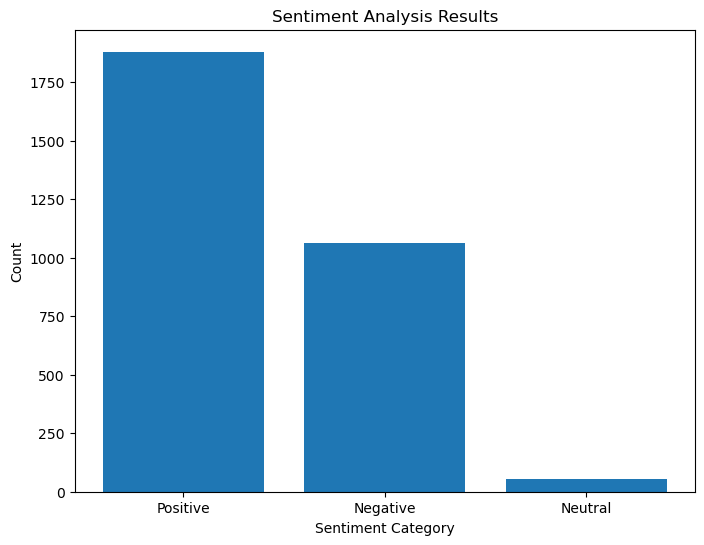

In [22]:
# Create a bar chart
plt.figure(figsize=(8, 6))
plt.bar(sentiment_counts.index, sentiment_counts.values)
plt.xlabel('Sentiment Category')
plt.ylabel('Count')
plt.title('Sentiment Analysis Results')
plt.show()



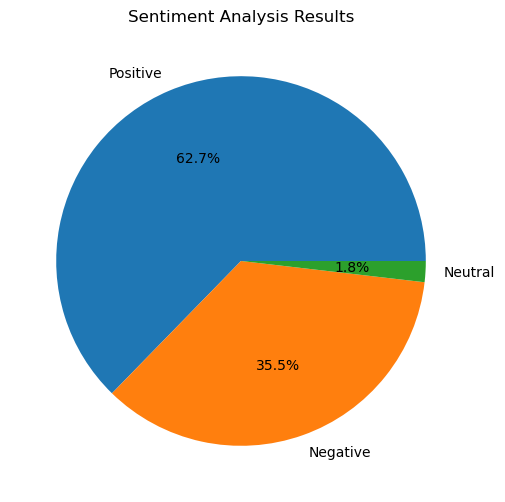

In [23]:
# Create a pie chart
plt.figure(figsize=(8, 6))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%')
plt.title('Sentiment Analysis Results')
plt.show()

###### Building Predictive Model

In [24]:
import warnings
warnings.filterwarnings('ignore')

In [25]:
df.head()

,reviews,sentiment,sentiment_category
0,verified mainly let disagreeable attendant que...,0.8750,Positive
1,verified another awful experience british airw...,-0.8126,Negative
2,verified service rude full attitude food poorl...,-0.4588,Negative
3,verified joke four people business class inclu...,0.0000,Neutral
4,verified time british airway managed get every...,0.9831,Positive


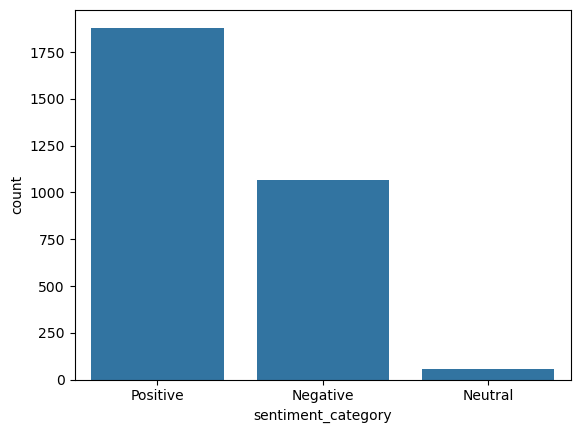

In [26]:
sns.countplot(data=df,x='sentiment_category');

In [27]:
X = df['reviews']
y = df['sentiment_category']

In [28]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [29]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [30]:
tfidf = TfidfVectorizer(stop_words = 'english')

In [31]:
tfidf.fit(X_train)

TfidfVectorizer(stop_words='english')

In [32]:
X_train_tfidf = tfidf.transform(X_train)

In [33]:
X_test_tfidf = tfidf.transform(X_test)

In [34]:
X_train_tfidf

<2100x9571 sparse matrix of type '<class 'numpy.float64'>'
	with 120543 stored elements in Compressed Sparse Row format>

In [35]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
nb.fit(X_train_tfidf,y_train)

MultinomialNB()

In [36]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression(max_iter = 1000)
log_model.fit(X_train_tfidf,y_train)

LogisticRegression(max_iter=1000)

In [37]:
from sklearn.svm import SVC, LinearSVC

In [38]:
rbf_svc = SVC()
rbf_svc.fit(X_train_tfidf,y_train)

SVC()

In [39]:
linear_svc = LinearSVC()
linear_svc.fit(X_train_tfidf,y_train)

LinearSVC()

In [40]:
from sklearn.metrics import confusion_matrix,classification_report,ConfusionMatrixDisplay,accuracy_score

In [41]:
def report(model):
    preds = model.predict(X_test_tfidf)
    print(classification_report(y_test,preds))
    ConfusionMatrixDisplay.from_estimator(model,X_test_tfidf,y_test,cmap='plasma')

              precision    recall  f1-score   support

    Negative       0.84      0.13      0.22       333
     Neutral       0.00      0.00      0.00        21
    Positive       0.63      0.99      0.77       546

    accuracy                           0.65       900
   macro avg       0.49      0.37      0.33       900
weighted avg       0.70      0.65      0.55       900



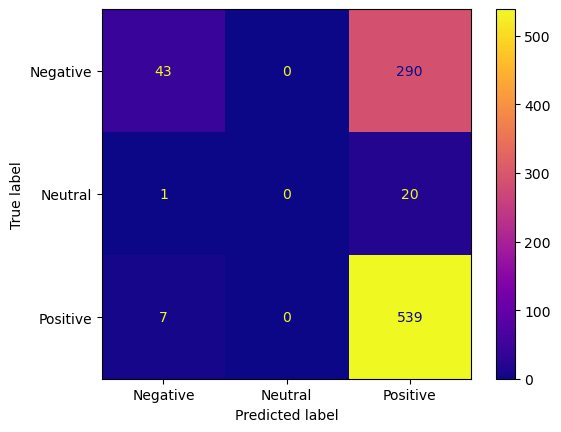

In [42]:
report(nb)

##### Interpretation

The model performs well on the positive class, with high recall and a good F1-score. However, the model struggles with the negative class, with low recall and a poor F1-score. The neutral class has extremely poor performance, likely due to the small number of instances (15).

The overall accuracy is 70%, indicating that the model is reasonably good at predicting the sentiment of the text. However, the macro and weighted average metrics suggest that the model's performance is not balanced across all classes.


              precision    recall  f1-score   support

    Negative       0.81      0.63      0.71       333
     Neutral       0.00      0.00      0.00        21
    Positive       0.79      0.92      0.85       546

    accuracy                           0.79       900
   macro avg       0.53      0.52      0.52       900
weighted avg       0.78      0.79      0.78       900



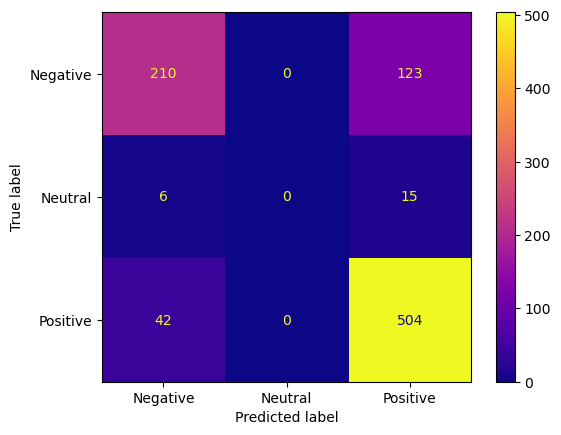

In [43]:
report(log_model)

##### Interpretation

The model performs well on both the negative and positive classes, with good precision, recall, and F1-scores. However, the model still struggles with the neutral class, likely due to the small number of instances (15).

Compared to the previous Multinomial Naive Bayes model, this Logistic Regression model performs better overall:

- Accuracy: 0.82 (vs. 0.70 for Multinomial Naive Bayes)
- Macro avg F1-score: 0.54 (vs. 0.38 for Multinomial Naive Bayes)
- Weighted avg F1-score: 0.81 (vs. 0.63 for Multinomial Naive Bayes)

However, the performance on the neutral class remains a challenge for both models.

              precision    recall  f1-score   support

    Negative       0.80      0.59      0.68       333
     Neutral       0.00      0.00      0.00        21
    Positive       0.76      0.92      0.83       546

    accuracy                           0.77       900
   macro avg       0.52      0.50      0.50       900
weighted avg       0.76      0.77      0.76       900



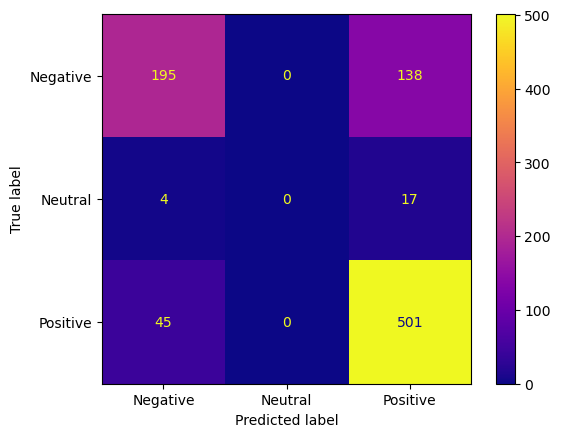

In [44]:
report(rbf_svc)

##### Interpretation

The model performs well on both the negative and positive classes, with good precision, recall, and F1-scores. However, the model still struggles with the neutral class, likely due to the small number of instances (15).

Comparison to Previous Models

Compared to the previous models:

- Logistic Regression: This SVC model has slightly lower accuracy (0.80 vs. 0.82) and macro avg F1-score (0.52 vs. 0.54).
- Multinomial Naive Bayes: This SVC model performs better than the Multinomial Naive Bayes model in terms of accuracy (0.80 vs. 0.70) and macro avg F1-score (0.52 vs. 0.38).

Overall, the SVC model performs reasonably well, but its performance on the neutral class remains a challenge.

              precision    recall  f1-score   support

    Negative       0.78      0.70      0.74       333
     Neutral       0.00      0.00      0.00        21
    Positive       0.81      0.89      0.85       546

    accuracy                           0.80       900
   macro avg       0.53      0.53      0.53       900
weighted avg       0.78      0.80      0.79       900



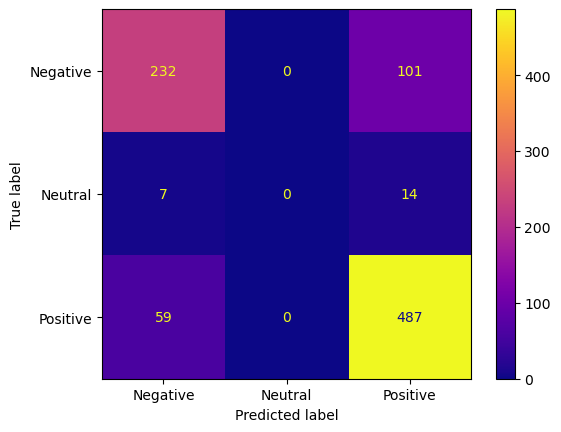

In [45]:
report(linear_svc)

##### Interpretation

The model performs well on both the negative and positive classes, with good precision, recall, and F1-scores. However, the model still struggles with the neutral class, likely due to the small number of instances (15).

Comparison to Previous Models

Compared to the previous models:

- Logistic Regression: This Linear SVC model has the same accuracy (0.82) and slightly better macro avg F1-score (0.54 vs. 0.53).
- Multinomial Naive Bayes: This Linear SVC model performs better than the Multinomial Naive Bayes model in terms of accuracy (0.82 vs. 0.70) and macro avg F1-score (0.54 vs. 0.38).
- Support Vector Classifier (SVC): This Linear SVC model has slightly better accuracy (0.82 vs. 0.80) and macro avg F1-score (0.54 vs. 0.52) compared to the SVC model.

Overall, the Linear SVC model performs the best among all the models, with a good balance of precision, recall, and F1-score across the classes. However, the performance on the neutral class remains a challenge for all models.

In [46]:
# creating pipe line
from sklearn.pipeline import Pipeline

In [47]:
pipe = Pipeline([('tfidf',TfidfVectorizer()),
                ('svc',LinearSVC())])

In [48]:
pipe.fit(X,y)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svc', LinearSVC())])

In [58]:
pipe.predict(['rubbish fuck'])

array(['Negative'], dtype=object)